In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import geeksw.hgcal.testbeam as hgc
import math
import scipy
from scipy.optimize import curve_fit

In [2]:
electron_runlist = hgc.runlist.query("Particle == 'electron'").query('Configuration == "22b"').groupby("Energy").apply(lambda x : x.iloc[1])
#electron_runlist = electron_runlist.reset_index()
energy = electron_runlist.Energy.values
electron_runlist

,Run,Date,Nevents,Particle,Energy,Configuration,CaloConfiguration
Energy,,,,,,,
20,437,2018-10-14 01:04:00,10274,electron,20,22b,1
30,595,2018-10-15 17:30:00,10291,electron,30,22b,1
50,457,2018-10-14 04:53:00,10050,electron,50,22b,1
80,467,2018-10-14 06:57:00,13423,electron,80,22b,1
100,479,2018-10-14 10:12:00,10240,electron,100,22b,1
120,621,2018-10-15 23:40:00,11361,electron,120,22b,1
150,494,2018-10-14 12:40:00,12220,electron,150,22b,1
200,665,2018-10-16 12:43:00,10239,electron,200,22b,1
250,385,2018-10-13 10:31:00,10161,electron,250,22b,1


In [ ]:
hdf = hgc.load_run(385, columns = ["beamEnergy","event", "rechit_layer", "rechit_X0", "rechit_energy"])

In [4]:
x0_max = hdf.query("rechit_layer == 28").rechit_X0.values[0]
x0_max

27.725000000000001

In [ ]:
total_sum = hdf.groupby(["event", "rechit_X0"]).sum()
total_sum = total_sum.reset_index()
total_sum = total_sum.groupby("rechit_X0").median()
total_sum = total_sum.reset_index()
total_sum["rechit_energy"] = total_sum["rechit_energy"]/total_sum["rechit_energy"].sum()
total_sum = total_sum[total_sum.rechit_X0 <= x0_max]

In [ ]:
hdf["rechit_X0_times_energy"] = hdf.rechit_energy * hdf.rechit_X0
gb = hdf.groupby("event")
cogs = []
cogs = gb["rechit_X0_times_energy"].sum() / gb["rechit_energy"].sum()

In [6]:
data = dict(
    beam_energy=[],
    cog=[],
    alpha=[],
    alpha_std=[],
    beta=[],
    beta_std=[],
    E=[],
    E_std=[],
)

In [7]:
electron_runlist = hgc.runlist.query("Particle == 'electron'").query('Configuration == "22b"').groupby("Energy").apply(lambda x : x.iloc[1])
#electron_runlist = electron_runlist.reset_index()
data["beam_energy"] = list(electron_runlist.Energy.values)

In [8]:
def grindhammer(t, alpha, beta, E):
    return E * ((beta*t)**(alpha-1)*beta*np.exp(-beta*t)) / scipy.special.gamma(alpha)

/opt/exp_soft/llr/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


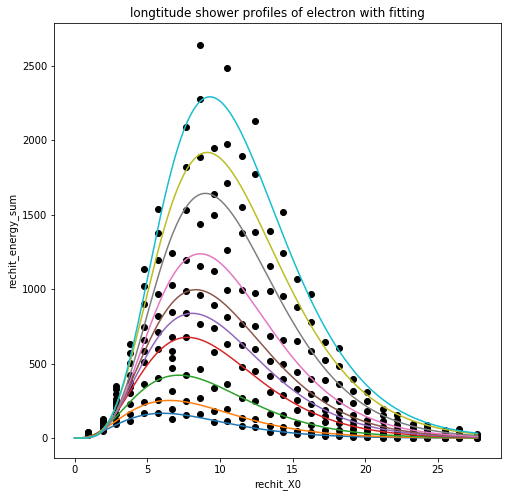

In [9]:
run_numbers = electron_runlist.Run.values
plt.figure(figsize=(8,8))
for run in run_numbers:
    hdf = hgc.load_run(run, columns = ["beamEnergy","event", "rechit_layer", "rechit_X0", "rechit_energy"])
    x0_max = hdf.query("rechit_layer == 28").rechit_X0.values[0]
    total_sum = hdf.groupby(["event", "rechit_X0"]).sum()
    total_sum = total_sum.reset_index()
    total_sum = total_sum.groupby("rechit_X0").median()
    total_sum = total_sum.reset_index()
    total_sum = total_sum[total_sum.rechit_X0 <= x0_max]
    #total_sum["rechit_energy"] = total_sum["rechit_energy"]/total_sum["rechit_energy"].sum()
    plt.scatter(total_sum.rechit_X0, total_sum.rechit_energy, color='k')
    data["cog"].append(np.sum(total_sum.rechit_X0 * total_sum.rechit_energy)/np.sum(total_sum.rechit_energy))
    popt, pcov = curve_fit(grindhammer, total_sum.rechit_X0, total_sum.rechit_energy, maxfev=2000)
    
    xx = np.linspace(0, np.max(total_sum.rechit_X0), 500)
    #xx = np.linspace(0, 28, 500)
    plt.plot(xx, grindhammer(xx, *popt))
    
    data["alpha"].append(popt[0])
    data["beta"].append(popt[1])
    data["E"].append(popt[2])
    data["alpha_std"].append(pcov[0,0]**0.5)
    data["beta_std"].append(pcov[1,1]**0.5)
    data["E_std"].append(pcov[2,2]**0.5)
profile_df = pd.DataFrame(data=data)
plt.xlabel("rechit_X0")
plt.ylabel("rechit_energy_sum")
plt.title("longtitude shower profiles of electron with fitting")
plt.show()


In [24]:
print (profile_df)

   beam_energy        cog     alpha  alpha_std      beta  beta_std  \
0           20   8.097662  3.758993   0.225639  0.455412  0.032795   
1           30   8.475658  3.975245   0.252915  0.456285  0.034460   
2           50   9.016998  4.371551   0.281563  0.469723  0.035326   
3           80   9.504677  4.791926   0.315870  0.488192  0.037042   
4          100   9.783597  5.018222   0.359086  0.496106  0.040596   
5          120   9.986610  5.218743   0.402824  0.505523  0.044384   
6          150  10.245812  5.488496   0.431840  0.518989  0.046144   
7          200  10.542728  5.765058   0.446125  0.529348  0.046016   
8          250  10.774445  5.561795   0.449091  0.499870  0.045569   
9          300  10.920077  5.798817   0.444909  0.515152  0.044393   

              E       E_std  
0   1571.351500   49.221411  
1   2465.045003   80.919430  
2   4242.153286  138.522269  
3   6912.097674  227.488697  
4   8659.443887  307.166478  
5  10346.538165  393.630695  
6  12896.521702  49

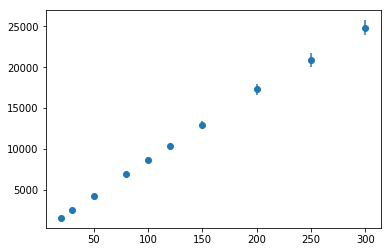

In [25]:
plt.errorbar(profile_df.beam_energy, profile_df.E, yerr=profile_df.E_std, fmt='o')
plt.show()

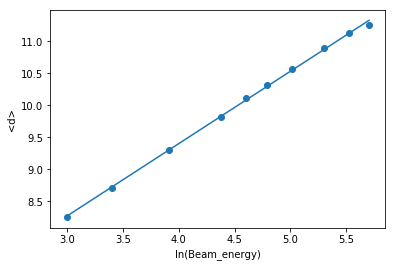

In [15]:
plt.scatter(np.log(profile_df.beam_energy),(profile_df.alpha)/profile_df.beta)
z1=np.polyfit(np.log(profile_df.beam_energy), (profile_df.alpha)/profile_df.beta,1)
p1=np.poly1d(z1)
yvals=p1(np.log(profile_df.beam_energy))
plot1=plt.plot(np.log(profile_df.beam_energy), yvals)
plt.xlabel("ln(Beam_energy)")
plt.ylabel("<d>")
plt.show()

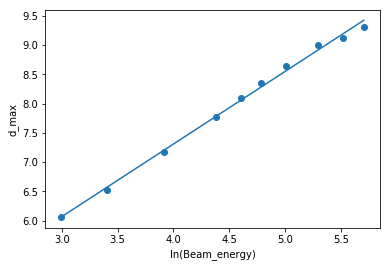

In [16]:
plt.scatter(np.log(profile_df.beam_energy),(profile_df.alpha -1)/profile_df.beta)
z1=np.polyfit(np.log(profile_df.beam_energy), (profile_df.alpha -1)/profile_df.beta,1)
p1=np.poly1d(z1)
yvals=p1(np.log(profile_df.beam_energy))
plot1=plt.plot(np.log(profile_df.beam_energy), yvals)
plt.xlabel("ln(Beam_energy)")
plt.ylabel("d_max")
plt.show()

In [13]:
z1=np.polyfit(np.log(profile_df.beam_energy), (profile_df.alpha -1)/profile_df.beta,1)
p1=np.poly1d(z1)
print (p1)

 
1.241 x + 2.346


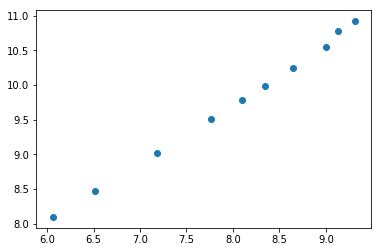

In [28]:
plt.scatter((profile_df.alpha -1)/profile_df.beta, profile_df.cog)

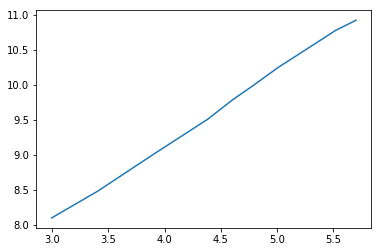

In [29]:
plt.plot(np.log(profile_df.beam_energy), profile_df.cog)

/opt/exp_soft/llr/python/3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


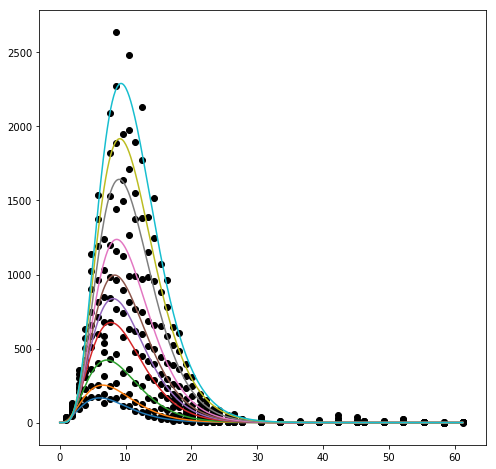

In [30]:
data = dict(
    beam_energy=[],
    cog=[],
    alpha=[],
    alpha_std=[],
    beta=[],
    beta_std=[],
    E=[],
    E_std=[],
)
electron_runlist = hgc.runlist.query("Particle == 'electron'").query('Configuration == "22b"').groupby("Energy").apply(lambda x : x.iloc[1])
#electron_runlist = electron_runlist.reset_index()
data["beam_energy"] = list(electron_runlist.Energy.values)
run_numbers = electron_runlist.Run.values
plt.figure(figsize=(8,8))
for run in run_numbers:
    hdf = hgc.load_run(run, columns = ["beamEnergy","event", "rechit_layer", "rechit_X0", "rechit_energy"])
    total_sum = hdf.groupby(["event", "rechit_X0"]).sum()
    total_sum = total_sum.reset_index()
    total_sum = total_sum.groupby("rechit_X0").median()
    total_sum = total_sum.reset_index()
    #total_sum["rechit_energy"] = total_sum["rechit_energy"]/total_sum["rechit_energy"].sum()
    plt.scatter(total_sum.rechit_X0, total_sum.rechit_energy, color='k')
    data["cog"].append(np.sum(total_sum.rechit_X0 * total_sum.rechit_energy)/np.sum(total_sum.rechit_energy))
    popt, pcov = curve_fit(grindhammer, total_sum.rechit_X0, total_sum.rechit_energy, maxfev=2000)
    
    xx = np.linspace(0, np.max(total_sum.rechit_X0), 500)
    #xx = np.linspace(0, 28, 500)
    plt.plot(xx, grindhammer(xx, *popt))
    
    data["alpha"].append(popt[0])
    data["beta"].append(popt[1])
    data["E"].append(popt[2])
    data["alpha_std"].append(pcov[0,0]**0.5)
    data["beta_std"].append(pcov[1,1]**0.5)
    data["E_std"].append(pcov[2,2]**0.5)
profile_df = pd.DataFrame(data=data)
plt.show()


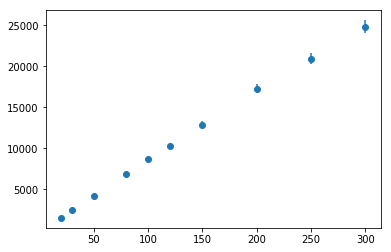

In [31]:
plt.errorbar(profile_df.beam_energy, profile_df.E, yerr=profile_df.E_std, fmt='o')
plt.show()

<ErrorbarContainer object of 3 artists>

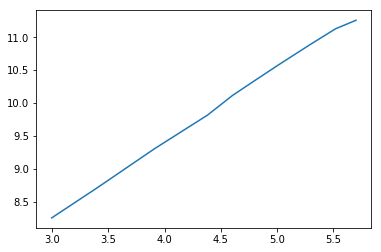

In [32]:
plt.errorbar(np.log(profile_df.beam_energy), (profile_df.alpha/profile_df.beta))

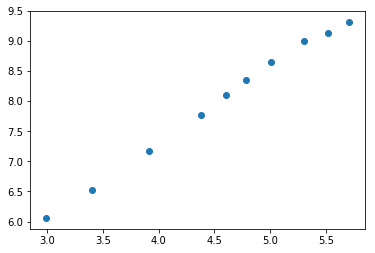

In [33]:
plt.scatter(np.log(profile_df.beam_energy),(profile_df.alpha -1)/profile_df.beta)

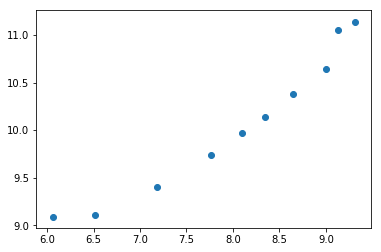

In [34]:
plt.scatter((profile_df.alpha -1)/profile_df.beta, profile_df.cog)

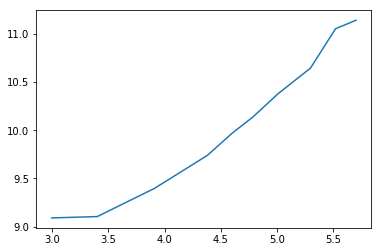

In [35]:
plt.plot(np.log(profile_df.beam_energy), profile_df.cog)